In [26]:
## Import Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Conv1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
file_name= pd.DataFrame(os.listdir(os.path.join('dataset')), columns= ['filename'])
seq_file= list(file_name[file_name.filename.str.contains('seq')].filename)

In [4]:
actions = ['love', 'come', 'heart', 'hello', 'deny']

data_np= np.empty([1, 30, 100])
for file in seq_file:
    data_np= np.append(data_np, np.load(os.path.join('dataset', file)), axis=0)
data= np.delete(data_np, [0], axis=0)

In [5]:
## data split for training
x_data= data[:, :, :-1]
labels= data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2685, 30, 99)
(2685,)


In [6]:
## one-hot-encoding
y_data= to_categorical(labels, num_classes=len(actions))

In [7]:
## data split
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2148, 30, 99) (2148, 5)
(537, 30, 99) (537, 5)


## Modelling

In [27]:
model = Sequential([
    Conv1D(filters= 128, kernel_size=4, strides=2, padding="valid", input_shape=x_train.shape[1:3]),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu', return_sequences=False),

    Dense(len(actions), activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        EarlyStopping(monitor= 'loss', mode= 'min', verbose= 1, patience= 15),
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 14, 64)            25408     
                                                                 
 lstm_21 (LSTM)              (None, 14, 64)            33024     
                                                                 
 lstm_22 (LSTM)              (None, 14, 32)            12416     
                                                                 
 lstm_23 (LSTM)              (None, 16)                3136      
                                                                 
 dense_14 (Dense)            (None, 5)                 85        
                                                                 
Total params: 74,069
Trainable params: 74,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
67/68 [============================>.]

Epoch 25/200
67/68 [============================>.] - ETA: 0s - loss: 0.1072 - acc: 0.9524
Epoch 25: val_acc did not improve from 0.95903
68/68 [==============================] - 3s 37ms/step - loss: 0.1070 - acc: 0.9525 - val_loss: 0.1325 - val_acc: 0.9460 - lr: 0.0010
Epoch 26/200
67/68 [============================>.] - ETA: 0s - loss: 0.1344 - acc: 0.9566
Epoch 26: val_acc did not improve from 0.95903
68/68 [==============================] - 3s 38ms/step - loss: 0.1342 - acc: 0.9567 - val_loss: 0.2107 - val_acc: 0.9404 - lr: 0.0010
Epoch 27/200
67/68 [============================>.] - ETA: 0s - loss: 0.1177 - acc: 0.9534
Epoch 27: val_acc improved from 0.95903 to 0.96648, saving model to models\model.h5
68/68 [==============================] - 3s 38ms/step - loss: 0.1175 - acc: 0.9534 - val_loss: 0.0965 - val_acc: 0.9665 - lr: 0.0010
Epoch 28/200
67/68 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9706
Epoch 28: val_acc did not improve from 0.96648
68/68 [=====

Epoch 55/200
67/68 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9767
Epoch 55: val_acc did not improve from 0.97765
68/68 [==============================] - 3s 37ms/step - loss: 0.0728 - acc: 0.9763 - val_loss: 0.0594 - val_acc: 0.9777 - lr: 0.0010
Epoch 56/200
67/68 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9767
Epoch 56: val_acc did not improve from 0.97765
68/68 [==============================] - 3s 38ms/step - loss: 0.0570 - acc: 0.9767 - val_loss: 0.0819 - val_acc: 0.9739 - lr: 0.0010
Epoch 57/200
67/68 [============================>.] - ETA: 0s - loss: 0.1378 - acc: 0.9594
Epoch 57: val_acc did not improve from 0.97765
68/68 [==============================] - 3s 38ms/step - loss: 0.1376 - acc: 0.9595 - val_loss: 0.1375 - val_acc: 0.9534 - lr: 0.0010
Epoch 58/200
67/68 [============================>.] - ETA: 0s - loss: 0.1364 - acc: 0.9538
Epoch 58: val_acc did not improve from 0.97765
68/68 [==============================] - 3s 37ms/

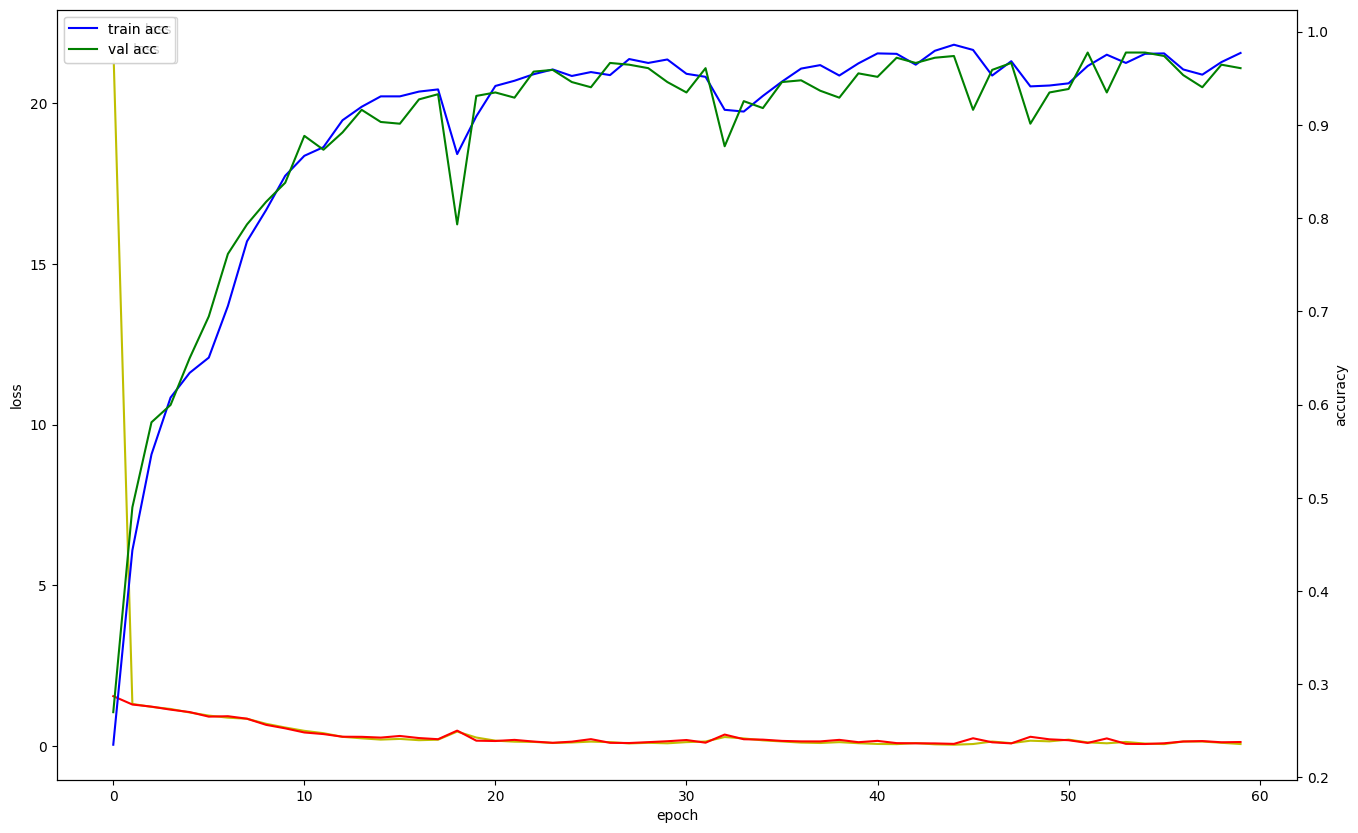

In [28]:
def vis_train_result(history):
    fig, loss_ax = plt.subplots(figsize=(16, 10))
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['acc'], 'b', label='train acc')
    acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()

vis_train_result(history)

In [29]:
## load model, inference, and cmap
model = load_model('models/model.h5')
y_pred = model.predict(x_val)
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

17/17 [==============================] - 1s 12ms/step


array([[[347,  89],
        [  5,  96]],

       [[417,   1],
        [ 11, 108]],

       [[436,   1],
        [ 75,  25]],

       [[428,   0],
        [  1, 108]],

       [[426,   3],
        [  2, 106]]], dtype=int64)

In [41]:
# Activities are the class labels
# It is a 6 class classification
labels = ['love', 'come', 'heart', 'hello', 'deny']

# Utility function to print the confusion matrix
from sklearn import metrics
def confusion_matrix_rnn(Y_true, Y_pred):
    Y_true = pd.Series([actions[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([actions[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)

In [35]:
# Confusion Matrix
print(confusion_matrix_rnn(y_val, model.predict(x_val)))

17/17 [==============================] - 0s 14ms/step
[[108   0   0   0  11]
 [  0 106   0   0   2]
 [  0   0  25   0  75]
 [  0   0   0 108   1]
 [  1   3   1   0  96]]


In [42]:
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(8,8))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 800x800 with 0 Axes>

17/17 [==============================] - 0s 16ms/step


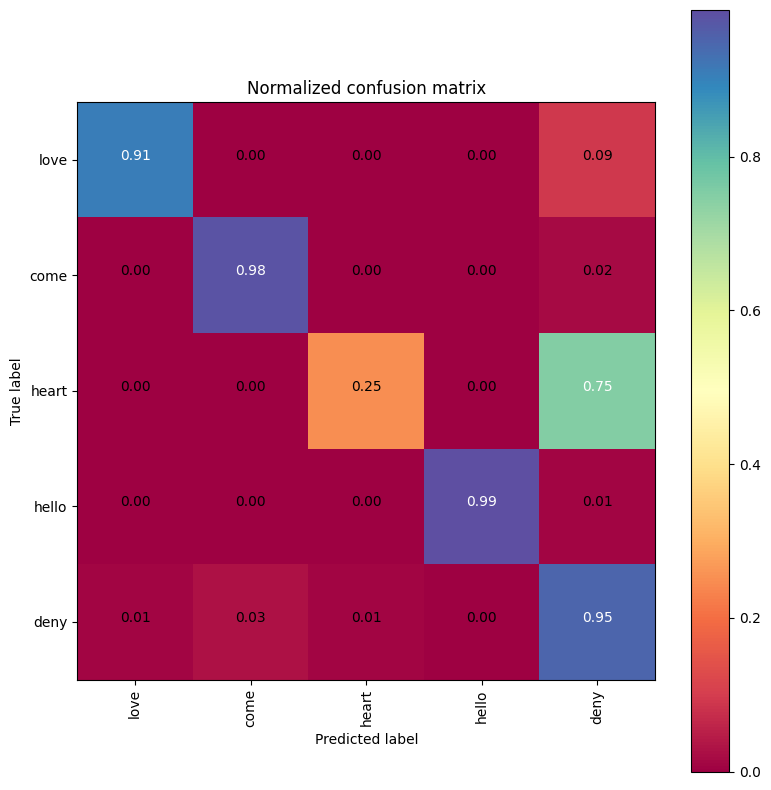

In [45]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_rnn(y_val, model.predict(x_val))
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Spectral)
plt.show()